# <center>Basic Feature Extraction</center>

Purpose of this notebook is to Engineer basic set of features before performing cleaning of the whole corpus. We will want to extract some basic features like count of Upper case words before performing data processing steps such as lower casing, etc.

- It is expected to observe a comment with intention to Abuse will have higher proportion of capitalized words, a less developed vocabulary and a higher number of exclamation points.

https://towardsdatascience.com/how-i-improved-my-text-classification-model-with-feature-engineering-98fbe6c13ef3

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365#:~:text=A%20simple%20approach%20could%20be,variance%20of%20the%20continuous%20variable.&text=If%20the%20variables%20have%20no,similar%20to%20the%20original%20variance.


# NOte:
    - calculate number of Sentences
    - Average Sentence length
    ON Preprocessed data.
    
    - add Upper_case_vs_words to train_pre_clean_features.csv and basic_fetaures_extraction.py

In [ ]:
# import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [148]:
import os.path
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif

from sklearn.linear_model import LogisticRegression

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
pd.set_option("display.max_colwidth", 1000)

In [159]:
# file_name = str(os.path.join(CLEANED_DATA_DIR, 'combined.csv'))

data = pd.read_csv("../cleaned_data/train_pre_clean_features.csv", encoding="utf-8")
data = data.sample(n=100000)#, random_state=42)

In [5]:
# data = data.drop(columns=['message'])

# <center>Analysis</center>

In [101]:
data.describe()

,word_count,char_count,avg_word_len,upper_case_words,numeric_count,word_density,punct_count,stop_word_count,num_unique_words,unique_vs_words,be_verb_count,Upper_case_vs_words,exclamation_count
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,53.128980,309.02549,4.985903,1.465370,0.234850,5.601499,0.257910,23.747100,41.806240,0.877602,4.401150,0.030181,0.344620
std,59.337791,352.71992,3.508649,8.966669,0.993814,1.908428,0.870391,27.291289,37.269082,0.107083,5.600732,0.076133,22.513681
min,1.000000,1.00000,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000,1.000000,0.002632,0.000000,0.000000,0.000000
25%,16.000000,92.00000,4.375000,0.000000,0.000000,5.125000,0.000000,6.000000,15.000000,0.800000,1.000000,0.000000,0.000000
50%,35.000000,198.00000,4.714286,1.000000,0.000000,5.521739,0.000000,15.000000,31.000000,0.888889,3.000000,0.008130,0.000000
75%,71.000000,414.00000,5.103659,2.000000,0.000000,5.893333,0.000000,33.000000,58.000000,1.000000,6.000000,0.037037,0.000000
max,2052.000000,10000.00000,223.000000,1314.000000,120.000000,111.500000,34.000000,976.000000,821.000000,1.000000,342.000000,1.000000,7056.000000


In [102]:

grp_0 = ['word_count', 'char_count', 'label']

grp_1 = ['avg_word_len', 'word_density',
         'stop_word_count', 'num_unique_words', 'unique_vs_words', 'be_verb_count', 
         'label']
grp_2 = ['upper_case_words', 'Upper_case_vs_words', 'numeric_count', 'punct_count', 'exclamation_count', 'label']

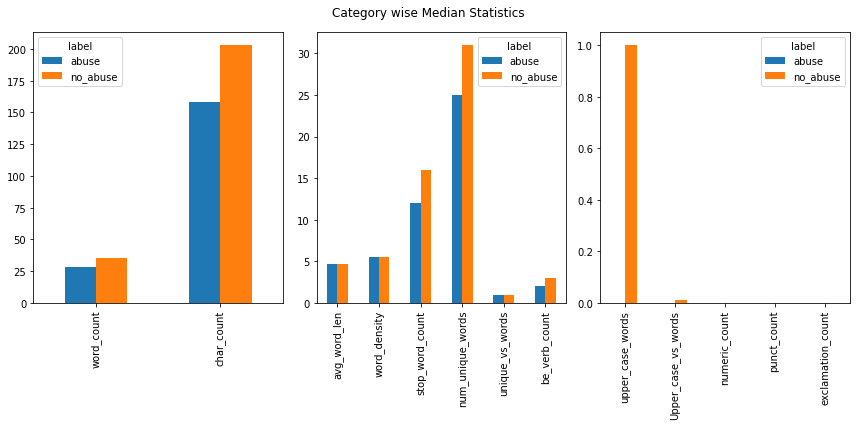

In [105]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

# plt.subplot(ax[0])
data[grp_0].groupby('label').median().T.plot(kind='bar', ax=ax[0])

# plt.subplot(ax[1])
data[grp_1].groupby('label').median().T.plot(kind='bar', ax=ax[1])

# plt.subplot(ax[2])
data[grp_2].groupby('label').median().T.plot(kind='bar', ax=ax[2])
# plt.yscale('log')

plt.suptitle("Category wise Median Statistics")
plt.tight_layout()
plt.show()

## Observation
- From descriptive statistics we can observe that most of the varibales are right skewed and thin tailed indicating presence of extreme outliers
- Median statistics does not indicate any major differences among the target categories.

# Mutual Information

In [92]:
num_importance = mutual_info_classif(X = data.drop(columns=['label', 'message']), y = data['label'],
                                     discrete_features=False, random_state=42)

In [98]:
temp_data = pd.DataFrame(data = np.column_stack((data.drop(columns=['label', 'message']).columns, num_importance)),
                         columns = ['feature', 'mutual_info']
                        )
temp_data.mutual_info = temp_data.mutual_info.astype('float').round(5)
temp_data.sort_values('mutual_info', ascending=False)

,feature,mutual_info
7,stop_word_count,0.00421
9,unique_vs_words,0.00382
3,upper_case_words,0.00321
4,numeric_count,0.00320
11,Upper_case_vs_words,0.00319
2,avg_word_len,0.00253
8,num_unique_words,0.00225
0,word_count,0.00192
12,exclamation_count,0.00182
10,be_verb_count,0.00180


## Observation on Mutual Information

Mutual Information statistics is not very encouraging and only ranking of the variables is considered. Although it must be noted that Mutual Information is susceptible to under estimating.

# Distribution of the Variables

In [145]:
def max_thresh(series):
    q1, q3 = np.percentile(series, [25, 75])
    iqr = q3 - q1
    max_th = q3 + 1.5*iqr
    return list(map(lambda x: max_th if x > iqr else x, series))

In [147]:
data_thresholded = data.drop(columns=['message'])

for column in data_thresholded.columns:
    if column!='label':
        data_thresholded[column] = max_thresh(data_thresholded[column])

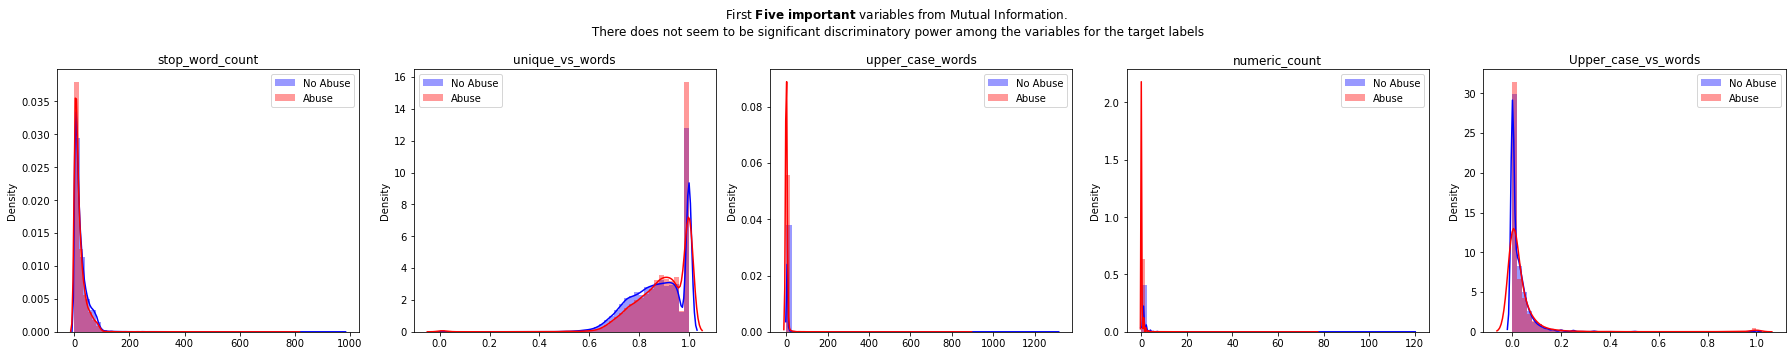

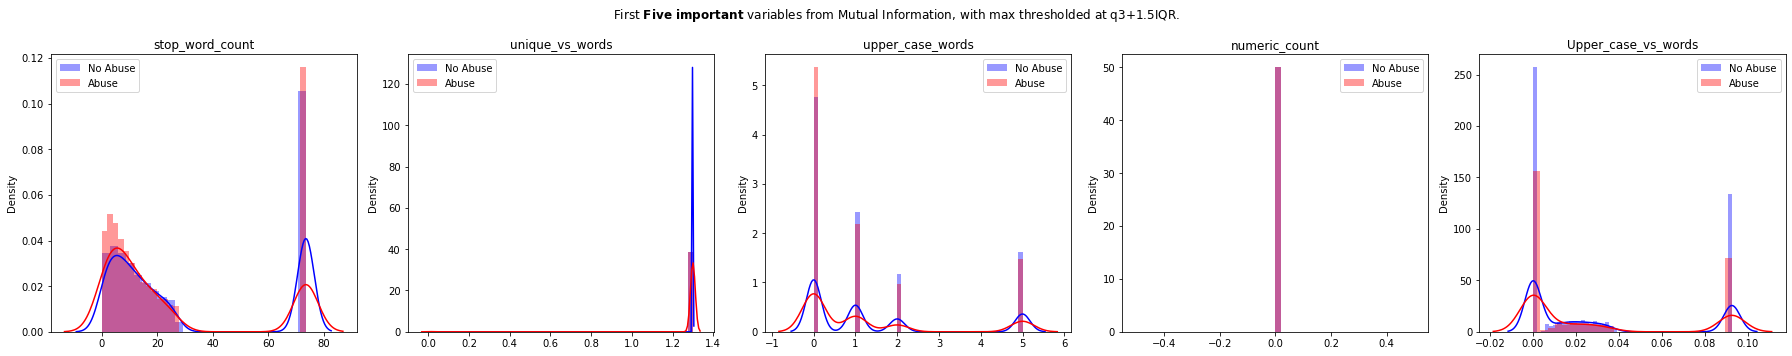

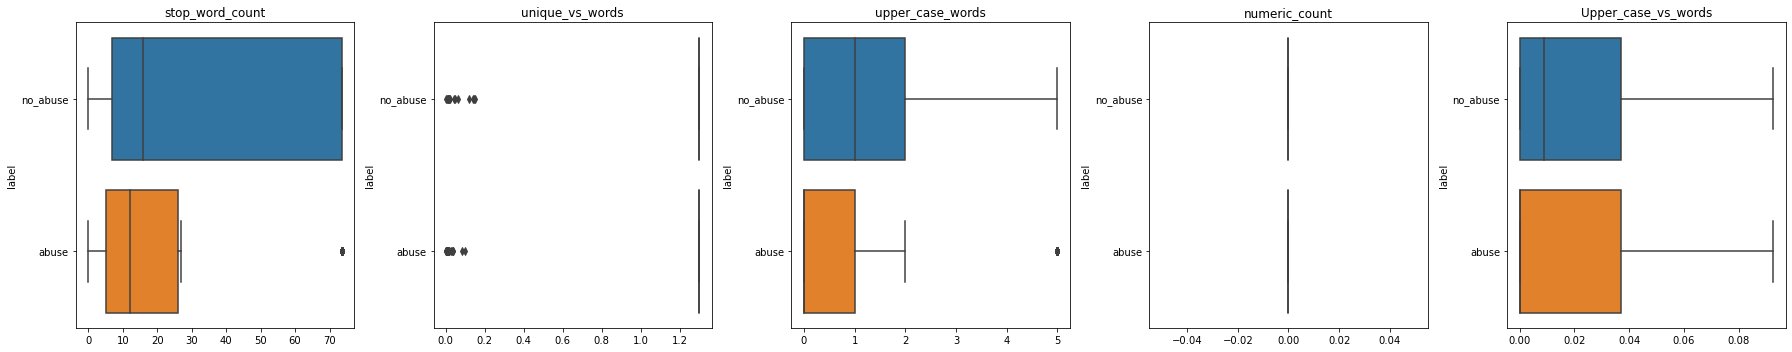

In [157]:
# columns = ['stop_word_count', 'unique_vs_words' , 'upper_case_words', 'numeric_count', 'Upper_case_vs_words']

# print()
# print('-'*50)

# for column in columns:
   
#     sns.distplot(data[column][data.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
#     sns.distplot(data[column][data.label == 'abuse'], color='r', hist=True, label='Abuse')
#     plt.xlabel('')
#     plt.title(column)

fig, ax = plt.subplots(1,5, figsize=(25,5))    

plt.subplot(ax[0])
sns.distplot(data['stop_word_count'][data.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data['stop_word_count'][data.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('stop_word_count')

plt.subplot(ax[1])
sns.distplot(data['unique_vs_words'][data.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data['unique_vs_words'][data.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('unique_vs_words')

plt.subplot(ax[2])
sns.distplot(data['upper_case_words'][data.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data['upper_case_words'][data.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('upper_case_words')

plt.subplot(ax[3])
sns.distplot(data['numeric_count'][data.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data['numeric_count'][data.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('numeric_count')

plt.subplot(ax[4])
sns.distplot(data['Upper_case_vs_words'][data.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data['Upper_case_vs_words'][data.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('Upper_case_vs_words')

first_five = r"$\bf{Five \ important}$"
plt.suptitle(f"First {first_five} variables from Mutual Information.\n There does not seem to be significant discriminatory power among the variables for the target labels")

plt.tight_layout()
plt.show()


############################ SECOND FIGURE #################################

fig, ax = plt.subplots(1,5, figsize=(25,5))  

plt.subplot(ax[0])

sns.distplot(data_thresholded['stop_word_count'][data_thresholded.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data_thresholded['stop_word_count'][data_thresholded.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('stop_word_count')

plt.subplot(ax[1])
sns.distplot(data_thresholded['unique_vs_words'][data_thresholded.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data_thresholded['unique_vs_words'][data_thresholded.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('unique_vs_words')

plt.subplot(ax[2])
sns.distplot(data_thresholded['upper_case_words'][data_thresholded.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data_thresholded['upper_case_words'][data_thresholded.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('upper_case_words')

plt.subplot(ax[3])
sns.distplot(data_thresholded['numeric_count'][data_thresholded.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data_thresholded['numeric_count'][data_thresholded.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('numeric_count')

plt.subplot(ax[4])
sns.distplot(data_thresholded['Upper_case_vs_words'][data_thresholded.label == 'no_abuse'], color='b', hist=True, label='No Abuse')
sns.distplot(data_thresholded['Upper_case_vs_words'][data_thresholded.label == 'abuse'], color='r', hist=True, label='Abuse')
plt.xlabel('')
plt.legend()
plt.title('Upper_case_vs_words')

plt.suptitle(r"First $\bf{Five \ important}$ variables from Mutual Information, with max thresholded at q3+1.5IQR.")

plt.tight_layout()
plt.show()


############################ THIRD FIGURE #################################


fig, ax = plt.subplots(1,5, figsize=(25,5))    

plt.subplot(ax[0])
sns.boxplot(y=data_thresholded.label, x=data_thresholded.stop_word_count)
plt.xlabel('')
plt.title('stop_word_count')

plt.subplot(ax[1])
sns.boxplot(y=data_thresholded.label, x=data_thresholded.unique_vs_words)
plt.xlabel('')
plt.title('unique_vs_words')

plt.subplot(ax[2])
sns.boxplot(y=data_thresholded.label, x=data_thresholded.upper_case_words)
plt.xlabel('')
plt.title('upper_case_words')

plt.subplot(ax[3])
sns.boxplot(y=data_thresholded.label, x=data_thresholded.numeric_count)
plt.xlabel('')
plt.title('numeric_count')

plt.subplot(ax[4])
sns.boxplot(y=data_thresholded.label, x=data_thresholded.Upper_case_vs_words)
plt.xlabel('')
plt.title('Upper_case_vs_words')

# plt.suptitle(r"First $\bf{Five \ important}$ variables from Mutual Information.")

plt.tight_layout()



In [26]:
# calculate the correlation statisitcs
corr = data.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

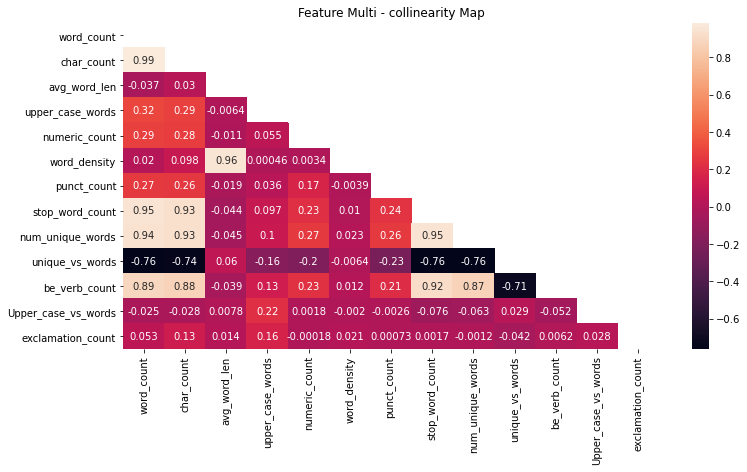

In [158]:
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, mask=mask)
plt.title('Feature Multi - collinearity Map')
plt.show()

## Observation for Correlation

**None** of the first five important variables from Mutual Information exhibit **Multi - collinearity**.

# Summary Take Away

- There does not seem to be much discriminatory power among the variables extracted from the pre cleaned data.
- However we are going to select top five features among these going by the order of mutual Information score. \
  However, we should be mindful that the scores are not very encouraging and will need further analysis in due course. \
  The features may be retained or droped using model based feature selection performed on combined features et form cleaned data.
- The selected features do not exhibit Multi - Collinearity.
- It was expectd the comments with abusive intent to be less richer in vocabulary. But data does not indicate the same.\
  There is a very slim chance of it being down to sample characteristcs, because experiment was repeated on multiple samples drawn at random.\
  It may be becaue we have data from various sources, where users behave differently. This may indicate that for such combined dataset traditional fetaure based approaches may not suffice. This however demands further inquiry.
